# Automatic Text Redaction for Government Documents

This notebook contains the code to run the experiments in the TPDL short paper, as well as instructions on how to work with the datasets that we have provided in the GitHub repository. We also provide code to run the complete algorithm on new images, to compute some statistics of the pages, and to time the algorithm.


## Index
1. [Text Redaction Algorithm](#algorithm)
    - 1.1 [Preprocessing](#preprocessing)
    - 1.2 [Text Removal](#text_removal)
    - 1.3 [Contour Detection](#contour_detection)
    - 1.4 [Contour Filtering](#contour_filtering)
2. [Algorithm Performance](#performance)
    - [Model Scores](#scores)
    - [Processing Times](#time)

In [1]:
# Imports
import os
import cv2
import json
import time
import pytesseract
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from pytesseract import Output
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from line_profiler import LineProfiler
from pdf2image import convert_from_path

%matplotlib inline

<a id="algorithm" />

## Detection Algorithm

Below we will implement the detection algorithm in separate functions, and show the output per step. The complete algorithm is also described in the paper.

In [2]:
test_image = '../datasets/images/wob-verzoek_omgevingsvergunning_terrein_nieuwendammerdijk_538-963594-page0.png'

In [3]:
# Simply load the PNG images
def load_image(image_path):
    # Checking if it is an image
    if image_path.lower().endswith('.png'):
        # Load the image
        image = cv2.imread(image_path)
    return image

Let's have a look at the test image, to see an example of the redaction present.

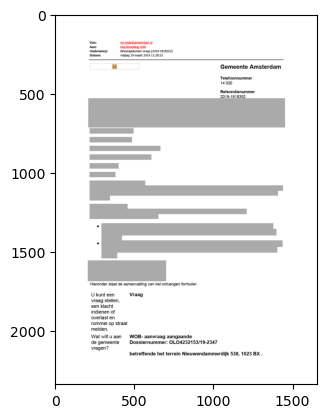

In [4]:
plt.imshow(load_image(test_image))
plt.show()

After the file load, we will start by doing the preprocessing, where we do this both for the text recognition, and the box recognition.

In [5]:
# load the test image
test_array = load_image(test_image)

As described in the paper, for the text processing we convert the image to grayscale, after which we apply the closing operation (dilation followed by erosion, to close some holes in text). For the redaction box preprocessing we will also convert the image to grayscale, and we will apply two opening operations, both horizontally and vertically, after which we apply a Gaussian blur.

<a id="preprocessing" />

## Preprocessing

In [6]:
# text preprocessing
def text_preprocessing(image):
    # For the text preprocessing convert the image to RGB
    image_grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # setup a 2 by 2 kernel for the closing
    kernel = np.ones((2,2), np.uint8)
    # we perform dilation followed by erosion, i.e. 'closing'
    closed_image = cv2.morphologyEx(image_grayscale, cv2.MORPH_CLOSE, kernel)
    
    image_blurred = cv2.GaussianBlur(closed_image, ksize=(3,3), sigmaX=0)

    return image_blurred

In [7]:

def redaction_box_preprocessing(image):
    image_grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    # We perform two sets of erosions and dilation, first horizontal, then vertical
    # these are also known as 'opening' operations, after which we apply a bilateral filter
    horizontal_kernel = np.ones((1,3), np.uint8)
    horizontally_opened_image = cv2.morphologyEx(image_grayscale, cv2.MORPH_OPEN, horizontal_kernel)
    # Apply kernel vertically
    vertical_kernel = np.ones((3,1), np.uint8)
    vertically_opened_image = cv2.morphologyEx(horizontally_opened_image, cv2.MORPH_OPEN, vertical_kernel)

    # Perform a bilateral blur
    bilateral_blurred_image = cv2.bilateralFilter(vertically_opened_image, 3, 75, 75)


    return bilateral_blurred_image


In [8]:
image_text_pre, image_box_pre = text_preprocessing(test_array), redaction_box_preprocessing(test_array)

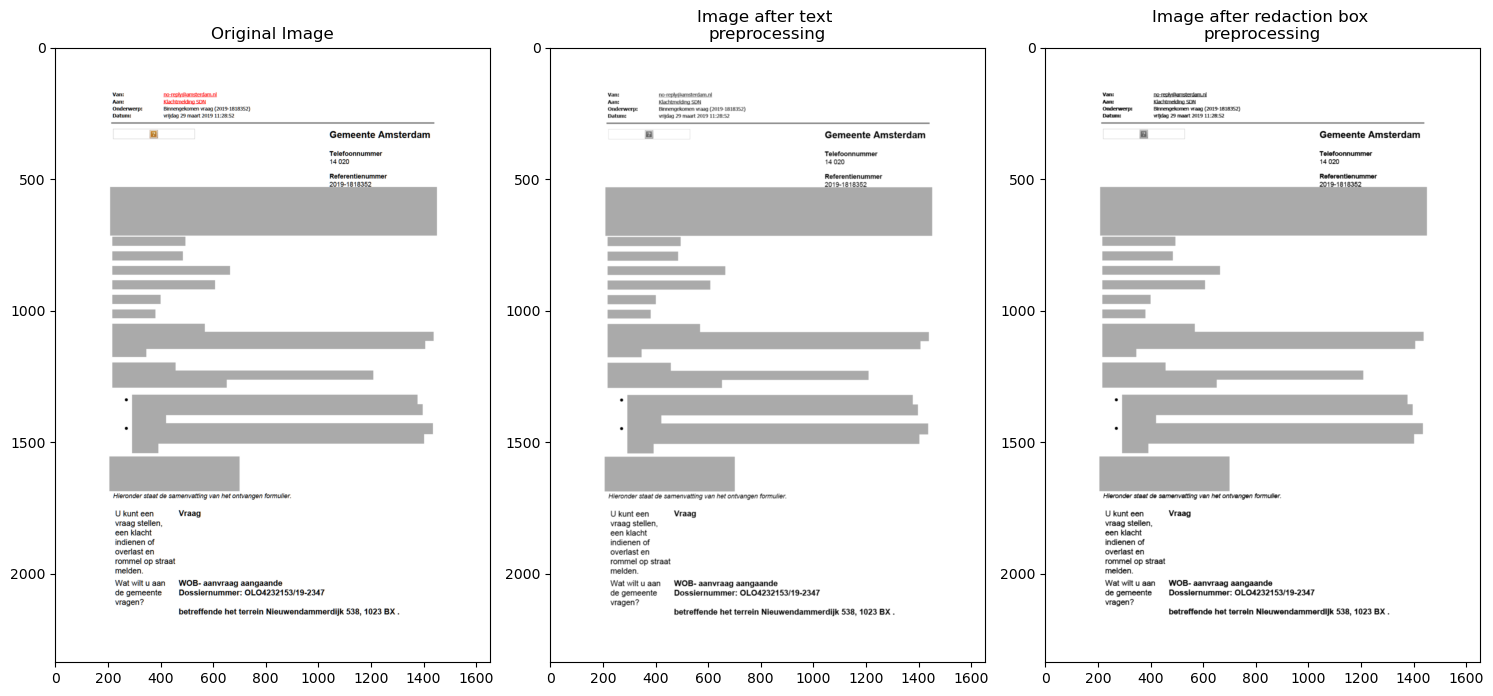

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

axes[0].imshow(test_array)
axes[0].set_title("Original Image")
axes[1].imshow(image_text_pre, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(image_box_pre, cmap='gray', vmin=0, vmax=255)
axes[1].set_title("Image after text \npreprocessing")
axes[2].set_title("Image after redaction box \npreprocessing")
plt.tight_layout()
plt.show()

In the image above we can see an example of the preprocessing, where the difference between the diferent images is not very big, apart from of course the conversion to grayscale.

<a id="text_removal" />

## Text Removal

In this step we remove the text from the image using Tesseract, where we will take care not to include any of the codes such as `5.1.1` and `5.1.2` in the detection of text, otherwise these redaction boxes would get removed and would not be able to be detected later on.

In [10]:
# Next step is text removal
def remove_text(original_image, text_image, redaction_box_image):
    # Count the total number of pixes of the pages occupied by words
    words_area = 0
    # Make a copy of the image where we will apply our transformation to.
    image_without_text = redaction_box_image.copy()
    # Get the width and height of the images
    image_height, image_width = original_image.shape[:2]

    # Set up the code to detect the leftmost and rightmost pieces of a page.
    left_boundary = [image_width]
    right_boundary = [0]
    top_boundary = [image_height]
    bottom_boundary = [0]

    # Specify the weighting codes
    weig_codes = ['5.1.1.', '5.1.2.']

    # run tesseract on the image preprocessed for text
    tesseract_output = pytesseract.image_to_data(text_image, lang='nld+eng', output_type=Output.DICT)
    # Get the OCR text
    ocr_text = ' '.join(tesseract_output['text'])
    # Get the height of the text
    height = np.array(tesseract_output['height'])
    # get the median height of the text, we will use this to calculate
    # how much of the page is occupied by words
    median_text_height = np.median(height[height < 0.3*image_height])

    # Get the number of detected text pages
    number_of_boxes = len(tesseract_output['level'])
    for box in range(number_of_boxes):
        # Get the coordinates of the text box
        if (tesseract_output['text'][box].strip() != "") and (tesseract_output['conf'][box] != -1) and (tesseract_output['height'][box] < 0.3*image_height):
            (x, y, w, h) = (tesseract_output['left'][box], tesseract_output['top'][box], tesseract_output['width'][box], tesseract_output['height'][box])

            if any([code in tesseract_output['text'][box] for code in weig_codes]):
                if len(tesseract_output['text'][box]) > 7:
                    sub_index = tesseract_output['text'][box].find('5.1.')
                    char_width = w / len(tesseract_output['text'][box])
                    w = int(char_width * 7)
                    x += int(char_width * sub_index)
                cv2.rectangle(image_without_text, (x, y), (x + w, y + h), (0, 0, 0), -1)
            elif tesseract_output['conf'][box] > 65:
                words_area += (w*h)
                cv2.rectangle(image_without_text, (x, y), (x + w, y + h), (255, 255, 255), -1)

                if median_text_height*1.1 > tesseract_output['height'][box] > median_text_height*0.9:
                    left_boundary.append(x)
                    right_boundary.append(x+w)
                    top_boundary.append(y)
                    bottom_boundary.append(y+h)

    image_without_text = cv2.threshold(image_without_text, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return image_without_text, words_area, {'left_boundary': min(left_boundary),
                                'right_boundary': max(right_boundary),
                                'top_boundary': min(top_boundary),
                               'bottom_boundary': max(bottom_boundary)}

In [11]:
image_without_text, total_word_area, text_boundaries = remove_text(test_array, image_text_pre, image_box_pre)

Let's plot the image without the text and only the bounding boxes of what we have left.

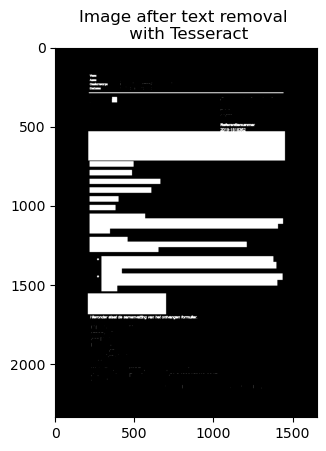

In [12]:
plt.imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
plt.title("Image after text removal \n with Tesseract")
plt.show()

This already looks quite good, but we can see that there is some text that did not get detected properly, such as at the bottom of the page and all the way at the top. In the next step we will get the contours of the redacted text and do some more filtering to get rid of these pieces of text.

<a id="contour_detection" />

## Contour Detection

After the text removal, we are going to clear the image up a bit more with more closing operations, after which we will extract the new contours.


In [13]:
# now we determine the contours
def determine_contours(image_without_text):

    # Fill rectangular contours
    contours = cv2.findContours(image_without_text, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for contour in contours:
        # filll contours with white
        cv2.drawContours(image_without_text, [contour], -1, (255,255,255), -1)

    # Here we remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    opened_image = cv2.morphologyEx(image_without_text, cv2.MORPH_OPEN, kernel, iterations=4)

    # Draw rectangles
    new_contours = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = new_contours[0] if len(new_contours) == 2 else new_contours[1]
    
    return opened_image, new_contours

In [14]:
image_with_contours, contours = determine_contours(image_without_text)

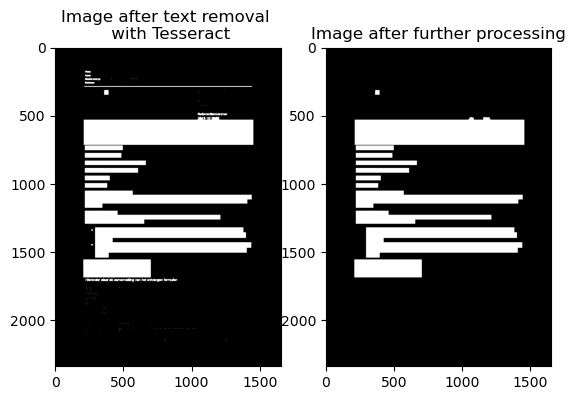

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Image after text removal \n with Tesseract")
axes[1].set_title("Image after further processing")
plt.show()

As we can see, some of the text that was missed by Tesseract has been properly removed now. The final step is a filtering step on these contours once again, now removing contours that are too small, or contours that are not rectangular.

<a id="contour_filtering" />

## Final Filtering Step

In [16]:
def filter_contours(original_image, contours, text_boundaries):
    
    final_image = original_image.copy()
    final_contour_image = np.zeros([original_image.shape[0], original_image.shape[1]], dtype=np.uint8)
    
    area_treshold_min = 0.000125 * original_image.shape[0] * original_image.shape[1]
    area_treshold_max = 0.4 * original_image.shape[0] * original_image.shape[1]

    left_text_boundary = [text_boundaries['left_boundary']]
    right_text_boundary = [text_boundaries['right_boundary']]
    top_text_boundary = [text_boundaries['top_boundary']]
    bottom_text_boundary = [text_boundaries['bottom_boundary']]
    
    redacted_bool = False
    number_of_redacted_regions = 0
    total_contour_area = 0

    final_contours = []

    for contour in contours:
        # Find extreme points of contours
        contour_left = tuple(contour[contour[:, :, 0].argmin()][0])
        contour_right = tuple(contour[contour[:, :, 0].argmax()][0])
        contour_top = tuple(contour[contour[:, :, 1].argmin()][0])
        contour_bottom = tuple(contour[contour[:, :, 1].argmax()][0])

        if area_treshold_max > cv2.contourArea(contour) > area_treshold_min and ((contour_bottom[1] - contour_top[1]) < (contour_right[0] - contour_left[0])):
            
            final_contours.append(contour)
            # add the contours into the final image
            cv2.drawContours(final_image, [contour], -1, (0,255, 0), -1)
            cv2.drawContours(final_contour_image, [contour], -1, (255, 255, 255), -1)

            left_text_boundary.append(contour_left[0])
            right_text_boundary.append(contour_right[0])
            top_text_boundary.append(contour_top[1])
            bottom_text_boundary.append(contour_bottom[1])
            
            total_contour_area += cv2.contourArea(contour)
            number_of_redacted_regions += 1

    text_area = ((max(right_text_boundary) - min(left_text_boundary)) * (max(bottom_text_boundary) - min(top_text_boundary)))

    
    return final_image, final_contour_image, final_contours, total_contour_area, text_area

In [17]:
final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(test_array, contours, text_boundaries)

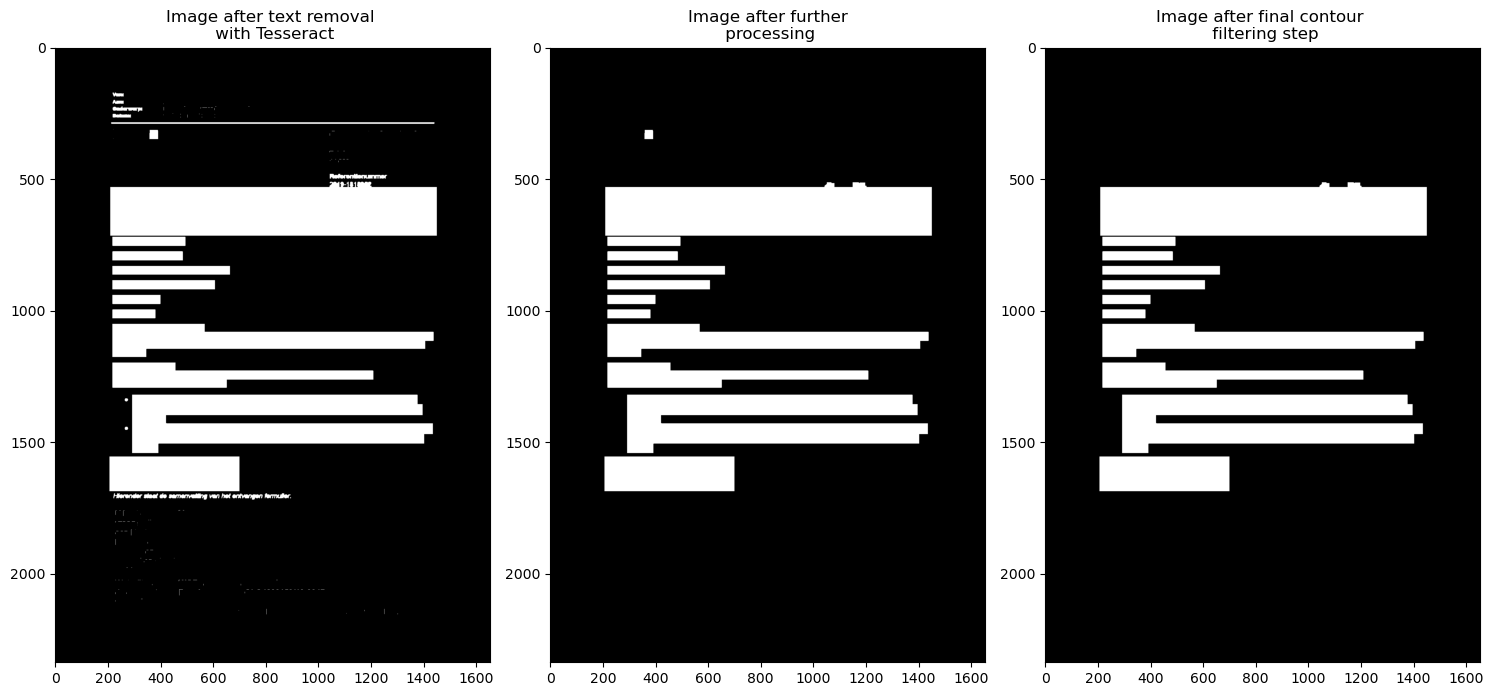

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
axes[0].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
axes[1].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
axes[2].imshow(final_contour_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title("Image after text removal \n with Tesseract")
axes[1].set_title("Image after further\n processing")
axes[2].set_title("Image after final contour \n filtering step")
plt.tight_layout()
plt.show()

Above we can now see that final step of the algorithm, and indeed some of the very small areas have now also been removed (the small score in the top center of the image for example).

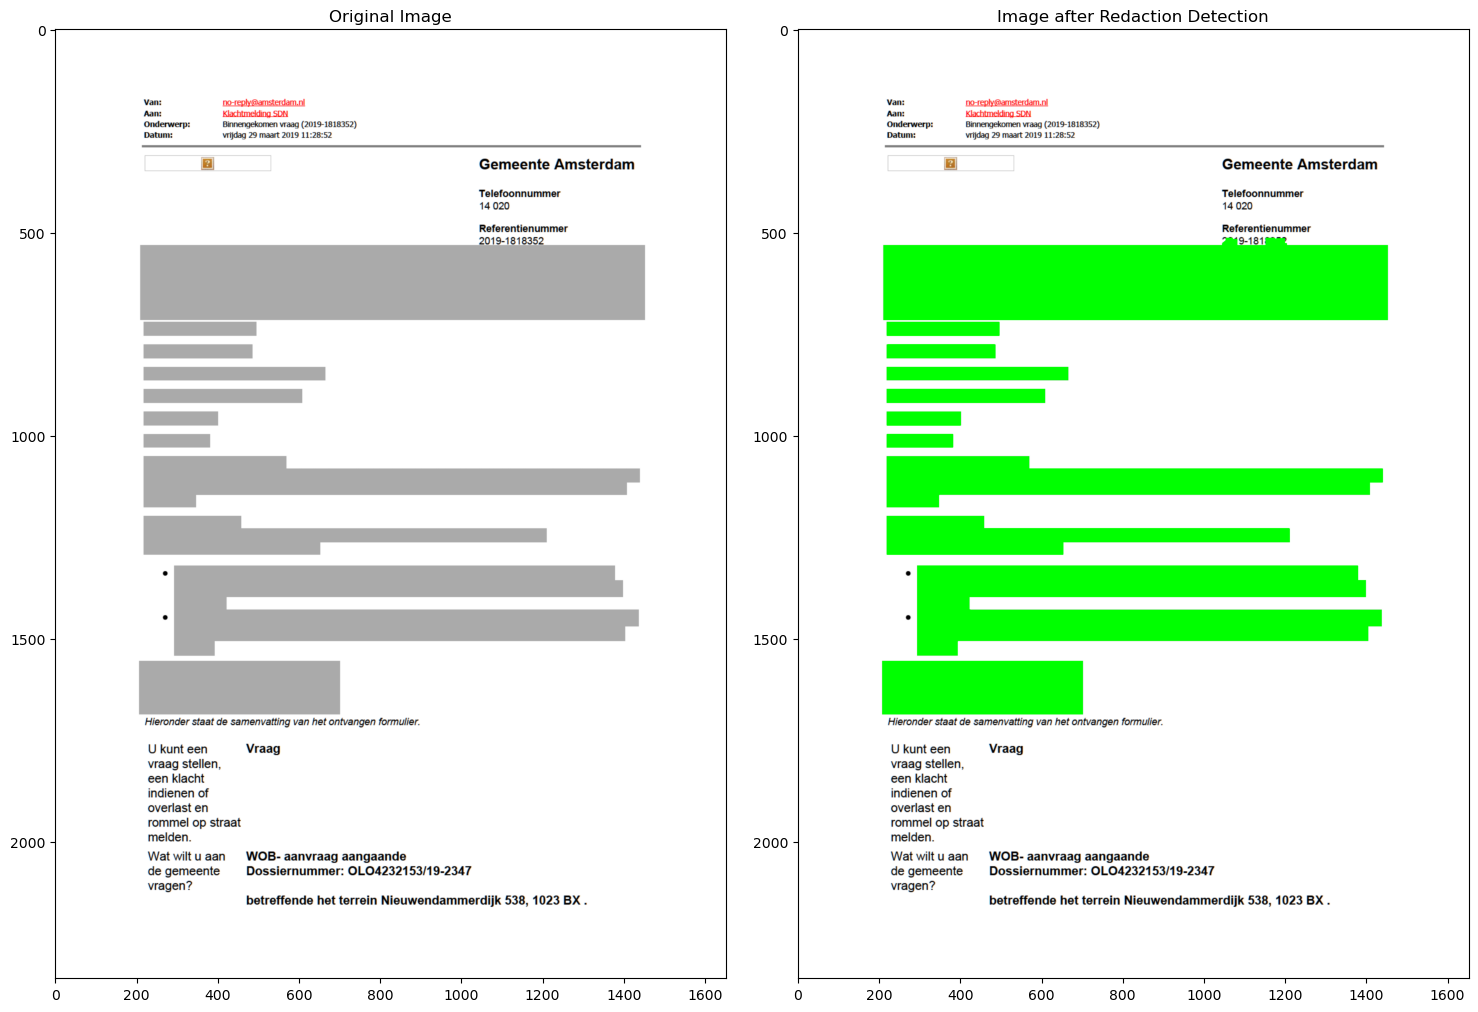

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

axes[0].imshow(test_array[:, :, :])
axes[0].set_title("Original Image")
axes[1].imshow(final_image_with_contours)
axes[1].set_title("Image after Redaction Detection")
plt.tight_layout()
plt.show()

We also provide a small function to run the algorithm and plot all steps.

In [20]:
def run_algorithm(input_image_path):
    input_image = load_image(input_image_path)
    # Do the preprocessing
    image_text_pre, image_box_pre = text_preprocessing(input_image), redaction_box_preprocessing(input_image)
    # Remove the text
    image_without_text, total_words_area, text_boundaries = remove_text(input_image, image_text_pre, image_box_pre)
    # First contour detection step
    image_with_contours, contours = determine_contours(image_without_text)
    # final contouring filtering step
    final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    
    # Automatically calculate some statistics on the number of redacted boxes, and the total percentage of 
    # the page that is redacted.
    # Check how much of the text area is redacted (%)
    percentage_redacted_textarea = ((total_contour_area / total_text_area) * 100) if total_contour_area and total_text_area else 0

    # Check how much of character area is redacted (%)
    total_area = total_contour_area + total_words_area
    percentage_redacted_words = ((total_contour_area / total_area) * 100) if total_contour_area else 0
    num_of_redacted_regions = len(final_contours)
    
    return final_contours

In [21]:
def visualize_algorithm_steps(input_image_path):
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 10))
    
    input_image = load_image(input_image_path)
    # Do the preprocessing
    image_text_pre, image_box_pre = text_preprocessing(input_image), redaction_box_preprocessing(input_image)
    # Remove the text
    image_without_text, total_words_area, text_boundaries = remove_text(input_image, image_text_pre, image_box_pre)
    # First contour detection step
    image_with_contours, contours = determine_contours(image_without_text)
    # final contouring filtering step
    final_image_with_contours, final_contour_image, final_contours, total_contour_area, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    
    axes[0].imshow(input_image)
    axes[1].imshow(image_text_pre, cmap='gray', vmin=0, vmax=255)
    axes[2].imshow(image_box_pre, cmap='gray', vmin=0, vmax=255)
    axes[3].imshow(image_without_text, cmap='gray', vmin=0, vmax=255)
    axes[4].imshow(image_with_contours, cmap='gray', vmin=0, vmax=255)
    axes[5].imshow(final_contour_image, cmap='gray', vmin=0, vmax=255)
    axes[6].imshow(final_image_with_contours)
    
    axes[0].set_title("Original image")
    axes[1].set_title("Text Preprocessing")
    axes[2].set_title("Redaction Box\n Preprocessing")
    axes[3].set_title("Text Removal")
    axes[4].set_title("Contour Detection")
    axes[5].set_title("Contour Filtering")
    axes[6].set_title("Final Image ")
    
    plt.tight_layout()
    plt.show()

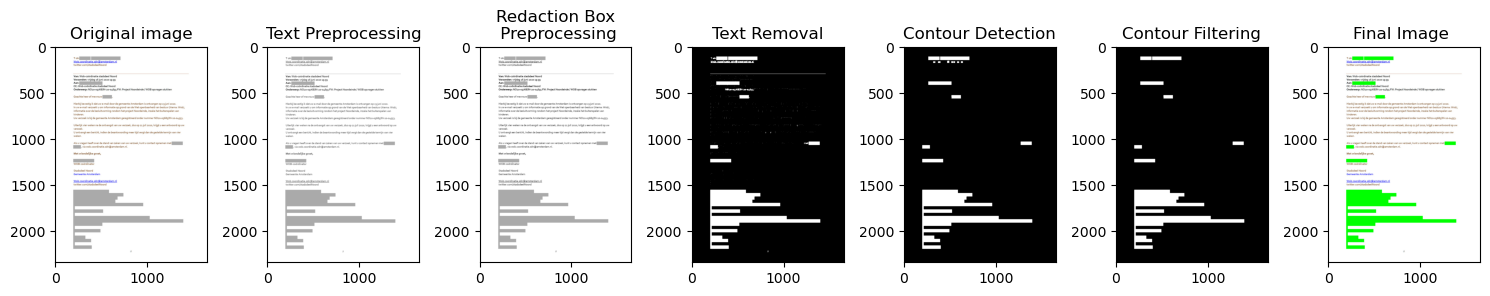

In [22]:
visualize_algorithm_steps('../datasets/images/wob-verzoek_project_noordeinde-963416-page1.png')

Now that we have the algorithm to detect redacted text in place, we can start using this to get some statistics of the page. We will write a small function that you can use to calculate these statistics per page.

<a id="performance" />

## Measuring model performance

In this part of the notebook we will run the scores on the testsets and evaluate using PQ. For this, we will be using the `annotations.json` file, which contains the annotations of the redacted text contours of the images. After this we will also time the different parts of the algorithm so that we get a clear understanding of what parts of the algorithms are most time consuming.

In [23]:
import json
def read_json(file_name):
    with open(file_name, 'r') as json_file:
        return json.load(json_file)

In [24]:
# Load in the files containing all the gold standard regions 
gold_standard = read_json('../datasets/gold_standard.json')

In [25]:
def evaluate_detection(input_image_filename):
    gold_standard_contours = gold_standard[input_image_filename.split('/')[-1]]
    predicted_contours = run_algorithm(input_image_filename)

    if type(gold_standard_contours['regions']) is dict:
        polygons = [r['shape_attributes'] for r in gold_standard_contours['regions']]
    else:
        polygons = [r['shape_attributes'] for r in gold_standard_contours['regions']]

    sum_IoU = 0

    points_pred = []
    for contour in predicted_contours:
        points = [item.tolist() for sublist in contour for item in sublist]
        points_pred.append(Polygon(points))

    points_GT = []
    
    for p in polygons:
        if p['name'] == 'rect':
            pol2_xy = [[p['x'], p['y']], [p['x']+p['width'], p['y']], [p['x']+p['width'], p['y']+p['height']], [p['x'], p['y']+p['height']]]
        else:
            pol2_xy = []
            for i in range(0, len(p['all_points_x'])):
                pol2_xy.append([p['all_points_x'][i], p['all_points_y'][i]])

        points_GT.append(Polygon(pol2_xy))
        
    points_GT.reverse()
    
    points_GT_count = points_GT.copy()

    count = 0

    matches = np.zeros((len(points_pred), len(points_GT)))
    for i in range(len(points_pred)):
        for j in range(len(points_GT_count)):
            index = points_GT.index(points_GT_count[j])
            polygon_intersection = points_pred[i].intersection(points_GT[index]).area
            polygon_union = points_pred[i].area + points_GT[index].area - polygon_intersection
            matches[i, index] = polygon_intersection / polygon_union
        
            if (polygon_intersection / polygon_union) >= 0.5:
                sum_IoU += (polygon_intersection / polygon_union)
                points_GT_count.remove(points_GT[index])
                break

    # Calculate false positives, false negatives and true positives and the PQ
    # score.
    TP = np.sum(np.any(matches>=0.5, axis=1))
    FP = np.sum(np.all(matches<0.5, axis=1))
    FN = np.sum(np.all(matches<0.5, axis=0))
    
    return {'TP': TP, 'FP': FP, 'FN': FN, 'IOU': sum_IoU}
    


<a id="scores" />

## Evaluation Using PQ

To evaluate on all the images, we have to load in the types of redacted text (which are also present in the json file). We then count the TP, FN, and FP for all images, and use this to calculate the final scores. We will work with dataframes here, as this is the easiest way to assign labels to the different pages.

In [26]:
page_csv = pd.read_csv('../datasets/data.csv')

In [27]:
def evaluate_dataframe(image_dataframe):
    all_scores = {}
    for _, row in tqdm(image_dataframe.iterrows()):
        path = '../datasets/images/%s' % row['File']
        image_scores = evaluate_detection(path)
        all_scores[row['File']] = image_scores
    return all_scores

In [28]:
all_scores = evaluate_dataframe(page_csv)

141it [04:26,  1.89s/it]


In [29]:
page_csv = page_csv.set_index('File')
results = pd.DataFrame(all_scores).T
#add the scores and statistic to the dataframe
complete_dataframe = page_csv.join(results)

In [30]:
def metric_calculation(dataframe):
    SQ = dataframe['IOU'].sum() / dataframe['TP'].sum()
    RQ = dataframe['TP'].sum() / (dataframe['TP'].sum() + 0.5*dataframe['FN'].sum() + 0.5*dataframe['FP'].sum())
    PQ = SQ*RQ
    P = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FP'].sum())
    R = dataframe['TP'].sum() / (dataframe['TP'].sum() + dataframe['FN'].sum())
    
    number_of_segments =  dataframe['TP'] + dataframe['FN']
    dataframe['num_segments'] = number_of_segments
    return round(SQ, 2), round(RQ, 2) , round(PQ, 2), round(P, 2), round(R, 2), dataframe
                                

In [31]:
type_results_table = {}
for _, df in complete_dataframe.groupby('label'):
    SQ, RQ, PQ, P, R, dataframe = metric_calculation(df)
    redacted_type = df['label'].tolist()[0]
    type_results_table[redacted_type] = {'SQ': SQ, 'RQ': RQ, 'PQ': PQ, 'P': P, 'R': R}

In [32]:
pd.DataFrame(type_results_table)

black  border  color  gray
SQ   0.92    0.88   0.89  0.90
RQ   0.79    0.58   0.88  0.69
PQ   0.73    0.52   0.79  0.62
P    0.85    0.70   0.85  0.77
R    0.75    0.50   0.92  0.63

<a id="time" />

## Timing the  complete function

To time the algorithm we wrote a small script that can time the execution times of individual functions so we can report them in the paper.

In [36]:
def time_algorithm(input_image_path):
    load_start = time.time()
    input_image = load_image(input_image_path)
    load_end = time.time()
    # Do the preprocessing
    pre_start = time.time()
    image_text_pre, image_box_pre = text_preprocessing(input_image), redaction_box_preprocessing(input_image)
    pre_end = time.time()
    # Remove the text
    remove_start = time.time()
    image_without_text, _, text_boundaries = remove_text(input_image, image_text_pre, image_box_pre)
    remove_end = time.time()
    # First contour detection step
    contour_det_start = time.time()
    image_with_contours, contours = determine_contours(image_without_text)
    contour_det_end = time.time()
    # final contouring filtering step
    final_step_start = time.time()
    final_image_with_contours, final_contour_image, final_contours, _, total_text_area  = filter_contours(input_image, contours, text_boundaries)
    final_step_end = time.time()
    
    times = {'loading': load_end-load_start,
            'preprocessing': pre_end-pre_start,
           'text_removal': remove_end-remove_start,
           'contour detection': contour_det_end-contour_det_start,
           'final filtering': final_step_end-final_step_start}
    
    times['total'] = sum(times.values())
    
    return times

In [37]:
# do this over all the images and average
load_times = []
preprocessing_times = []
text_removal_times = []
contour_detection_times = []
final_filtering_times = []
total_times = []

for image_path in tqdm(glob('../datasets/**/*.png')):
    times = time_algorithm(image_path)
    load_times.append(times['loading'])
    preprocessing_times.append(times['preprocessing'])
    text_removal_times.append(times['text_removal'])
    contour_detection_times.append(times['contour detection'])
    final_filtering_times.append(times['final filtering'])
    total_times.append(times['total'])
    

100%|███████████████████████████████████████████| 141/141 [04:25<00:00,  1.89s/it]


In [38]:
print("Average loading time is %.3f seconds" % np.mean(load_times))
print("Average preprocessing time is %.3f seconds" % np.mean(preprocessing_times))
print("Average text removal time is %.3f seconds" % np.mean(text_removal_times))
print("Average contour detection time is %.3f seconds" % np.mean(contour_detection_times))
print("Average final filtering time is %.3f seconds" % np.mean(final_filtering_times))

Average loading time is 0.048 seconds
Average preprocessing time is 0.018 seconds
Average text removal time is 1.792 seconds
Average contour detection time is 0.014 seconds
Average final filtering time is 0.008 seconds
